The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Fatoração de Matriz
 :cite:`Koren.Bell.Volinsky.2009` 
 
Fatoração de matrizes é um algoritmo bem estabelecido na literatura de sistemas de recomendação. A primeira versão do modelo de fatoração de matrizes é proposta por Simon Funk em um famoso [blog post](https://sifter.org/~simon/journal/20061211.html) em que descreveu a ideia de fatorar a matriz de interação. Em seguida, tornou-se amplamente conhecido devido ao concurso Netflix realizado em 2006. Naquela época, a Netflix, uma empresa de streaming de mídia e locação de vídeo, anunciou um concurso para melhorar o desempenho de seu sistema de recomendação. A melhor equipe que puder melhorar na linha de base do Netflix, ou seja, Cinematch), em 10 por cento ganharia um prêmio de um milhão de dólares. Como tal, este concurso atraiu
muita atenção ao campo de pesquisa de sistemas de recomendação. Posteriormente, o grande prêmio foi ganho pela equipe Pragmatic Chaos da BellKor, uma equipe combinada de BellKor, Pragmatic Theory e BigChaos (você não precisa se preocupar com esses algoritmos agora). Embora a pontuação final tenha sido o resultado de uma solução de conjunto (ou seja, uma combinação de muitos algoritmos), o algoritmo de fatoração de matriz desempenhou um papel crítico na mistura final. O relatório técnico da solução do Grande Prêmio Netflix :cite:`Toscher.Jahrer.Bell.2009` fornece uma introdução detalhada ao modelo adotado. Nesta seção, vamos mergulhar nos detalhes do modelo de fatoração de matriz e sua implementação.


## O modelo de fatoração de matriz

A fatoração de matriz é uma classe de modelos de filtragem colaborativa. Especificamente, o modelo fatoriza a matriz de interação usuário-item (por exemplo, matriz de classificação) no produto de duas matrizes de classificação inferior, capturando a estrutura de classificação inferior das interações usuário-item.

Seja $\mathbf{R} \in \mathbb{R}^{m \times n}$ a matriz de interação com $m$ usuários e $n$ itens, e os valores de $\mathbf{R}$ representam explícito avaliações. A interação usuário-item será fatorada em uma matriz latente de usuário $\mathbf{P} \in \mathbb{R}^{m \times k}$ e uma matriz latente de item $\mathbf{Q} \in \mathbb{R}^{n \times k}$, onde $k \ll m, n$, é o tamanho do fator latente. Deixe $\mathbf{p}_u$ denotar a linha $u^\mathrm{th}$ linha de $\mathbf{P}$ denotar a $i^\mathrm{th}$ linha de $\mathbf{Q}$.. Para um determinado item $i$, os elementos de $\mathbf{q}_i$ medem até que ponto o item possui essas características, como gêneros e idiomas de um filme. Para um dado usuário $u$, os elementos de $\mathbf{p}_u$ medem a extensão do interesse que o usuário tem nas características correspondentes dos itens. Esses fatores latentes podem medir dimensões óbvias conforme mencionado nesses exemplos ou são completamente ininterpretáveis. As classificações previstas podem ser estimadas por

$$\hat{\mathbf{R}} = \mathbf{PQ}^\top$$

onde $\hat{\mathbf{R}}\in \mathbb{R}^{m \times n}$ é a matriz de avaliação prevista que tem a mesma forma de $\mathbf{R}$. Um grande problema dessa regra de predição é que os vieses de usuários/itens não podem ser modelados. Por exemplo, alguns usuários tendem a dar classificações mais altas ou alguns itens sempre obtêm classificações mais baixas devido à qualidade inferior. Esses preconceitos são comuns em aplicativos do mundo real. Para capturar essas tendências, são introduzidos termos de tendência específicos do usuário e do item. Especificamente, a avaliação prevista que o usuário $u$ dá ao item $i$ é calculada por


$$
\hat{\mathbf{R}}_{ui} = \mathbf{p}_u\mathbf{q}^\top_i + b_u + b_i
$$

Em seguida, treinamos o modelo de fatoração de matriz minimizando o erro quadrático médio entre as pontuações de classificação previstas e as pontuações de classificação reais. A função objetivo é definida da seguinte forma:

$$
\underset{\mathbf{P}, \mathbf{Q}, b}{\mathrm{argmin}} \sum_{(u, i) \in \mathcal{K}} \| \mathbf{R}_{ui} -
\hat{\mathbf{R}}_{ui} \|^2 + \lambda (\| \mathbf{P} \|^2_F + \| \mathbf{Q}
\|^2_F + b_u^2 + b_i^2 )
$$

onde $\lambda$ denota a taxa de regularização. O termo de regularização $\lambda (\| \mathbf{P} \|^2_F + \| \mathbf{Q}
\|^2_F + b_u^2 + b_i^2 )$ é usado para evitar sobreajuste penalizando a magnitude dos parâmetros. Os pares $(u, i)$ pelos quais $\mathbf{R}_{ui}$ é conhecido são armazenados no conjunto
$\mathcal{K}=\{(u, i) \mid \mathbf{R}_{ui} \text{ is known}\}$. Os parâmetros do modelo podem ser aprendidos com um algoritmo de otimização, como Stochastic Gradient Descent e Adam.

Uma ilustração intuitiva do modelo de fatoração de matriz é mostrada abaixo:

![Ilustração do modelo de fatoração de matriz](../img/rec-mf.svg)

No restante desta seção, explicaremos a implementação da fatoração da matriz e treinaremos o modelo no conjunto de dados MovieLens.


In [1]:
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Implementação do Modelo

Primeiro, implementamos o modelo de fatoração de matriz descrito acima. Os fatores latentes do usuário e do item podem ser criados com o `nn.Embedding`. O `input_dim` é o número de itens / usuários e o (`output_dim`) é a dimensão dos fatores latentes ($ k $). Também podemos usar `nn.Embedding` para criar os vieses de usuário / item definindo `output_dim` para um. Na função `forward`, os ids do usuário e do item são usados para pesquisar os embeddings.


In [2]:
class MF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()

## Medidas de Avaliação

Em seguida, implementamos a medida RMSE (erro quadrático médio), que é comumente usada para medir as diferenças entre as pontuações de classificação previstas pelo modelo e as classificações realmente observadas (verdade do terreno) :cite:`Gunawardana.Shani.2015`. RMSE é definido como:

$$
\mathrm{RMSE} = \sqrt{\frac{1}{|\mathcal{T}|}\sum_{(u, i) \in \mathcal{T}}(\mathbf{R}_{ui} -\hat{\mathbf{R}}_{ui})^2}
$$

onde $\mathcal{T}$ é o conjunto que consiste em pares de usuários e itens que você deseja avaliar. $|\mathcal{T}|$ é o tamanho deste conjunto. Podemos usar a função RMSE fornecida por `mx.metric`.


In [3]:
def evaluator(net, test_iter, devices):
    rmse = mx.metric.RMSE()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = gluon.utils.split_and_load(users, devices, even_split=False)
        i = gluon.utils.split_and_load(items, devices, even_split=False)
        r_ui = gluon.utils.split_and_load(ratings, devices, even_split=False)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse.update(labels=r_ui, preds=r_hat)
        rmse_list.append(rmse.get()[1])
    return float(np.mean(np.array(rmse_list)))

## Treinamento e avaliação do modelo


Na função de treinamento, adotamos a perda de $L_2$ com queda de peso. O mecanismo de redução de peso tem o mesmo efeito que a regularização $L_2$.


In [4]:
#@save
def train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None,
                        **kwargs):
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                            legend=['train loss', 'test RMSE'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            timer.start()
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            train_feat = input_data[0:-1] if len(values) > 1 else input_data
            train_label = input_data[-1]
            with autograd.record():
                preds = [net(*t) for t in zip(*train_feat)]
                ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        if len(kwargs) > 0:  # It will be used in section AutoRec
            test_rmse = evaluator(net, test_iter, kwargs['inter_mat'],
                                  devices)
        else:
            test_rmse = evaluator(net, test_iter, devices)
        train_l = l / (i + 1)
        animator.add(epoch + 1, (train_l, test_rmse))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test RMSE {test_rmse:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

Finalmente, vamos juntar todas as coisas e treinar o modelo. Aqui, definimos a dimensão do fator latente para 30.


train loss 0.066, test RMSE 1.050
49324.0 examples/sec on [gpu(0), gpu(1)]


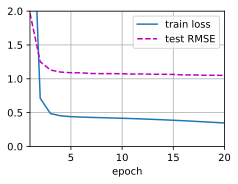

In [5]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = d2l.split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)
net = MF(30, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, evaluator)

Abaixo, usamos o modelo treinado para prever a classificação que um usuário (ID 20) pode dar a um item (ID 30).


In [6]:
scores = net(np.array([20], dtype='int', ctx=devices[0]),
             np.array([30], dtype='int', ctx=devices[0]))
scores

array([3.0987508], ctx=gpu(0))

## Sumário

* O modelo de fatoração de matriz é amplamente utilizado em sistemas de recomendação. Ele pode ser usado para prever classificações que um usuário pode dar a um item.
* Podemos implementar e treinar a fatoração de matrizes para sistemas de recomendação.


## Exercícios

* Varie o tamanho dos fatores latentes. Como o tamanho dos fatores latentes influencia o desempenho do modelo?
* Experimente diferentes otimizadores, taxas de aprendizado e taxas de redução de peso.
* Verifique as pontuações de classificação previstas de outros usuários para um filme específico.


[Discussão](https://discuss.d2l.ai/t/400)


<!--stackedit_data:
eyJoaXN0b3J5IjpbNjczOTUyNjQ5LC0xODU5NjAzMDIzXX0=
-->
